In [1]:
import pandas as pd
import sqlite3
 
# connecting to the database
conn = sqlite3.connect("gfg.db")
# cursor
crsr = conn.cursor()

In [2]:
brands = pd.read_csv("brands.csv").to_sql('brands', conn)
receipt_items = pd.read_csv("receipt_items.csv").to_sql('receipt_items', conn)
receipts = pd.read_csv("receipts.csv").to_sql('receipts', conn)
users = pd.read_csv("users.csv").to_sql('users', conn)

In [19]:
# Which brand saw the most dollars spent in the month of June?
pd.read_sql( """
SELECT B.NAME
FROM Receipt_items AS RI
INNER JOIN Receipts AS RE ON RI.REWARDS_RECEIPT_ID = RE.ID 
INNER JOIN Brands AS B ON B.BARCODE = RI.BARCODE
WHERE strftime('%m', RE.PURCHASE_DATE) = '06'
GROUP BY B.NAME
ORDER BY SUM(RI.TOTAL_FINAL_PRICE) DESC
LIMIT 1
""", conn)

,NAME
0,Brooks®


In [7]:
# Which user spent the most money in the month of August? 
pd.read_sql("""
SELECT U.ID, RE.TOTAL_SPENT, RE.PURCHASE_DATE
FROM Users AS U
INNER JOIN Receipts AS RE on RE.USER_ID = U.ID
WHERE strftime('%m', PURCHASE_DATE) = '08' AND RE.TOTAL_SPENT = (SELECT MAX(RE.TOTAL_SPENT)
                                                        FROM Receipts AS RE)
ORDER BY RE.TOTAL_SPENT DESC
""", conn)

,ID,TOTAL_SPENT,PURCHASE_DATE
0,609ab37f7a2e8f2f95ae968f,93015.18,2021-08-17T00:00:00Z


In [8]:
#What user bought the most expensive item?
pd.read_sql( """
SELECT U.ID
FROM Users AS U
INNER JOIN Receipts AS RE on RE.USER_ID = U.ID
INNER JOIN Receipt_items AS RI on RI.REWARDS_RECEIPT_ID = RE.ID
WHERE RI.TOTAL_FINAL_PRICE = (SELECT MAX(RI.TOTAL_FINAL_PRICE)
                            FROM Receipt_items AS RI)
GROUP BY U.ID
""", conn)

,ID
0,617376b8a9619d488190e0b6


In [10]:
# What is the name of the most expensive item purchased?
pd.read_sql("""
            SELECT RI.DESCRIPTION, RI.TOTAL_FINAL_PRICE
            FROM receipt_items as RI
            JOIN receipts as RE
            ON RI.REWARDS_RECEIPT_ID = RE.ID
            ORDER BY TOTAL_FINAL_PRICE DESC 
            LIMIT 1
            """, conn)

,DESCRIPTION,TOTAL_FINAL_PRICE
0,Starbucks Iced Coffee Premium Coffee Beverage ...,31005.99


In [18]:
# How many users scanned in each month?
pd.read_sql( """
SELECT strftime('%m', DATE_SCANNED) AS month, COUNT(U.ID)
FROM Users AS U
INNER JOIN Receipts AS RE ON RE.USER_ID = U.ID
GROUP BY MONTH
""", conn)

,month,COUNT(U.ID)
0,01,4222
1,02,3830
2,03,4767
3,04,4882
4,05,5627
5,06,5405
6,07,6058
7,08,6191
8,09,6355
9,10,7305


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data into pandas dataframes
users = pd.read_csv('users.csv')
receipts = pd.read_csv('receipts.csv')
brands = pd.read_csv('brands.csv')
receipt_items = pd.read_csv('receipt_items.csv')

First I wanted to check how many missing values there were in each csv file/table, and so I used to the .isnull() function alongside .sum() to see how many values in each column were missing, then I assigned the total missing value count as a value in a dictionary to the name of the table to later plot as a graph.

In [25]:
nulldict = dict()
usersnull = users.isnull().sum()
print('USERS')
print(usersnull)
nulldict['users'] = (usersnull.sum())

receiptsnull = receipts.isnull().sum()
print('RECEIPTS')
print(receiptsnull)
nulldict['receipts'] = receiptsnull.sum()

brandsnull = brands.isnull().sum()
print('BRANDS')
print(brandsnull)
nulldict['brands'] = brandsnull.sum()

receipt_itemsnull = receipt_items.isnull().sum()
print('RECEIPT_ITEMS')
print(receipt_itemsnull)
nulldict['receipt_items'] = receipt_itemsnull.sum()

USERS
CREATED_DATE           0
BIRTH_DATE             0
GENDER                 0
LAST_REWARDS_LOGIN     0
STATE                  0
SIGN_UP_PLATFORM      45
SIGN_UP_SOURCE         0
ID                     0
dtype: int64
RECEIPTS
ID                               0
STORE_NAME                    1836
PURCHASE_DATE                 2066
PURCHASE_TIME                 4947
DATE_SCANNED                     0
TOTAL_SPENT                   1492
REWARDS_RECEIPT_STATUS           0
USER_ID                          0
USER_VIEWED                   6465
PURCHASED_ITEM_COUNT          1452
CREATE_DATE                      0
PENDING_DATE                  1453
MODIFY_DATE                      2
FLAGGED_DATE                 66576
PROCESSED_DATE               70601
FINISHED_DATE                 6252
REJECTED_DATE                66217
NEEDS_FETCH_REVIEW           70276
DIGITAL_RECEIPT                  0
DELETED                      69733
NON_POINT_EARNING_RECEIPT     8986
dtype: int64
BRANDS
ID               

<BarContainer object of 4 artists>

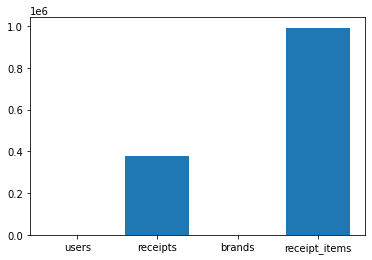

In [26]:
tables = list(nulldict.keys())
null_amount = list(nulldict.values())

plt.bar(range(len(nulldict)), null_amount, tick_label=tables)

Based off the results of this code, we can see that there is not that much wrong when it comes to the data in users and brands, however there are a significant amount of missing data in both the receipt and receipt_items data. For example, the receipt_items table has over 200,000 missing values in the BRAND_CODE column which can cause issues when joining this table with the Brands table and trying to analyze data. This would definetely be something that is concerning and should be shared with a stakeholder as to why it isn't being tracked correctly or efficiently. 

Next, I wanted to show a graph showing the number of users logged per month. This is just a visualization of the SQL query I did for the last question that was asked. 

Text(0.5, 1.0, 'Growth of Users By Month')

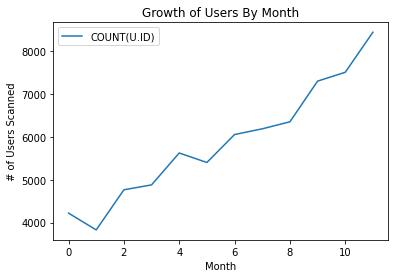

In [32]:
userspermonth = pd.read_sql( """
SELECT strftime('%m', DATE_SCANNED) AS month, COUNT(U.ID)
FROM Users AS U
INNER JOIN Receipts AS RE ON RE.USER_ID = U.ID
GROUP BY MONTH
""", conn)
userspermonth.plot()
plt.xlabel("Month")
plt.ylabel("# of Users Scanned")
plt.title("Growth of Users By Month")

You can see a pretty basic linear trend here. Essentially, this is telling us that on average, month over month, the number of users scanning in receipts per month is growing. This is a good sign of growth within the company, and would be very informative to show to stakeholders. I think that these types of visualizations are what are important to share to non-technical stakeholders because they are easy to read and understand.

In [34]:
crsr.close()
conn.close()